# **CNN - Weather Dataset**

## [Step 01] 라이브러리 로딩

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

In [ ]:
!nvidia-smi

Fri Feb 10 04:37:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    29W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## [Step 02] 데이터셋 로딩

- Reference: https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset

> GitHub에서 Weather 데이터셋 다운로드

In [2]:
!git clone https://github.com/hmjeon/Lec-DLCV # git clone을 통해 해당 깃허브 페이지에 있는 파일들을 다운 받음
%cd Lec-DLCV/dataset/dataset_weather # 해당 디렉토리를 기본 path로 지정

Cloning into 'Lec-DLCV'...
remote: Enumerating objects: 1625, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 1625 (delta 2), reused 5 (delta 1), pack-reused 1613
Receiving objects: 100% (1625/1625), 199.88 MiB | 41.76 MiB/s, done.
Resolving deltas: 100% (63/63), done.
/content/Lec-DLCV/dataset/dataset_weather


> 데이터 로딩

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)), # transforms.Resize이미지 사이즈를 통일시킴
    transforms.RandomHorizontalFlip(), # train data만 이미지를 돌려서 변형시킴(augmentation?)
    transforms.ToTensor(), # 이미지를 tensor형태로 변형
    transforms.Normalize( # 이미지의 픽셀 값들을 0~1사이로 변형 -> 정규화
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [4]:
# 학습용 데이터셋
train_dataset = datasets.ImageFolder(
    root='train/', # train폴더에 있는 이미지를 불러 앞에서 cd를 통해 기본 path를 변경해주었기 때문에 이렇게 사용할 수 있음
    transform=transform_train
)

# 데이터 사이즈 -> 학습용 : 검증용 = 8 : 2
dataset_size = len(train_dataset)
train_size = int(dataset_size * 0.8)
val_size = dataset_size - train_size

# 학습용 데이터 셋과 검증용 데이터 셋으로 나누기
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# 테스트 데이터 셋
test_dataset = datasets.ImageFolder(
    root='test/',
    transform=transform_test
)

# dataloader를 사용해 배치사이즈 적용시키기
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

## [Step 03] 데이터 시각화

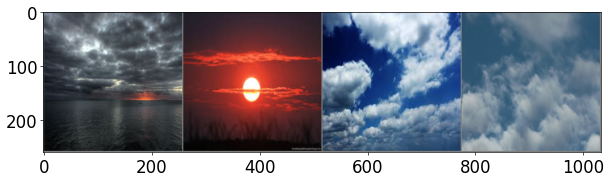

['Cloudy', 'Sunrise', 'Cloudy', 'Cloudy']


In [5]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.show()

    
class_names = {
  0: "Cloudy",
  1: "Rain",
  2: "Shine",
  3: "Sunrise"
}

# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
imgs, labels = next(iterator)
out = torchvision.utils.make_grid(imgs[:4])
imshow(out)
print([class_names[labels[i].item()] for i in range(4)])

## [Step 04] 딥러닝 모델 학습

- 사전 학습된(pre-trained) 딥러닝 모델을 이용하여 사용자 데이터셋 학습
- Fully connected layer의 마지막 레이어를 수정, 클래스 개수를 일치

In [ ]:
# 간단한 network 설계
class Model1(nn.Module):
  def __init__(self):
    super().__init__()
    self.lin = nn.Linear(256*256*3,4)
    self.flat = nn.Flatten()

  def foward(self, x):
    x = self.flat(x)
    x = self.lin(x)
    return x

In [6]:
learning_rate = 0.01
log_step = 20

model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)   # 마지막 레이어에 클래스 개수를 일치
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [7]:
import time

def train():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):
        imgs, labels = batch # 64개의 이미지로 이루어진 배치가 들어오면 imgs -> tensor(256,256,3,54)이고 label -> 정답(4, 64)
        imgs, labels = imgs.cuda(), labels.cuda()
        
        # step1
        outputs = model(imgs)
        
        #
        _, preds = torch.max(outputs, 1)
        
        # step2
        loss = criterion(outputs, labels)
        
        # step3
        loss.backward()
        
        # step4
        optimizer.step()
        optimizer.zero_grad()

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()


# validation과 test에서는 weight가 업데이트되면 안됨!
def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Validation]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad(): # gradient를 구하지 말라는 의미 -> weight 업데이트 안됨
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running val loss: {running_loss / total}, running val accuracy: {running_corrects / total}')

    print(f'val loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

# validation과 test에서는 weight가 업데이트되면 안됨!
def test():
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad(): # gradient를 구하지 말라는 의미 -> weight 업데이트 안됨
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [8]:
import time

def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 3:
        lr /= 10
    if epoch >= 7:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

num_epochs = 10
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch) # epoch가 증가하면 lr은 감소하도록
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f'best_checkpoint_epoch_{epoch + 1}.pth')

torch.save(model.state_dict(), f'last_checkpoint_epoch_{num_epochs}.pth')

[Epoch: 1 - Training]
train loss: 0.01159756550082454, accuracy: 0.7140740752220154
elapsed time: 22.55723738670349
[Epoch: 1 - Validation]
[Batch: 1] running val loss: 0.0015778262168169022, running val accuracy: 0.984375
val loss: 0.002603518098769103, accuracy: 0.9585798978805542
elapsed time: 2.5664732456207275
[Info] best validation accuracy!
[Epoch: 2 - Training]
train loss: 0.0010987104185753399, accuracy: 0.9792592525482178
elapsed time: 17.200108766555786
[Epoch: 2 - Validation]
[Batch: 1] running val loss: 0.00039559139986522496, running val accuracy: 0.984375
val loss: 0.0013697508987061372, accuracy: 0.9644970297813416
elapsed time: 2.702901840209961
[Info] best validation accuracy!
[Epoch: 3 - Training]
train loss: 0.0004594170716073778, accuracy: 0.9896296262741089
elapsed time: 16.63456439971924
[Epoch: 3 - Validation]
[Batch: 1] running val loss: 0.00047356836148537695, running val accuracy: 0.984375
val loss: 0.0011152946583089039, accuracy: 0.9704142212867737
elapsed 

## [Step 05] 학습 결과 가시화

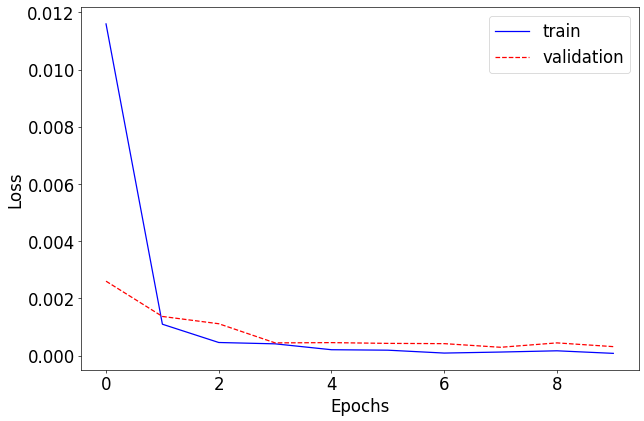

In [9]:
plt.plot([x[0] for x in history], 'b', label='train')
plt.plot([x[1] for x in history], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

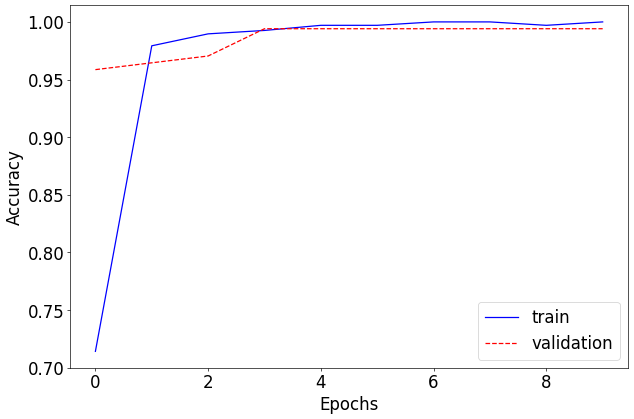

In [10]:
plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [11]:
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)   # 클래스 개수 일치
model = model.cuda()
model_path = 'best_checkpoint_epoch_6.pth'
model.load_state_dict(torch.load(model_path))

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

FileNotFoundError: ignored